# In this assignment we learn how to derive a neural network emultor based on the cosmopower emulator (Mancini et al. 2021). Based on this emualtor we perform a PCA data compression.

### For this assignment you need the install cosmopower yourself https://github.com/alessiospuriomancini/cosmopower or you just use the cosmopower_NN.py module that is provided. However in the latter case you need to install tensorflow: https://www.tensorflow.org/install

In [2]:
import matplotlib.pyplot as plt
import random
import numpy as np
from numpy.linalg import inv
import tensorflow as tf
from cosmopower_NN import cosmopower_NN

## Preparation: load in the all the 10000 model vectors and corresponding parameters that we use to bulit the emulator.

In [3]:
models = np.load('data_4_assignment2/models.npy') 
parameters = np.load('data_4_assignment2/parameters.npz')
parameters.keys(),models.shape

(KeysView(NpzFile 'data_4_assignment2/parameters.npz' with keys: omega_m, omega_b, As, w),
 (10000, 900))

#### Divide the models and parameters in a training and test set. 

In [7]:
train_sample = np.arange(0,1000) # select which elements you wanna use for training
test_sample = np.arange(1000,10000) # select which elements you wanna use for training

train_params = {}
for name in parameters.keys():
    train_params[name]=list(np.array(parameters[name])[train_sample])
    
test_params = {}
for name in parameters.keys():
    test_params[name]=list(np.array(parameters[name])[test_sample])

train_features = np.load('data_4_assignment2/models.npy')[train_sample]
test_features = np.load('data_4_assignment2/models.npy')[test_sample]

print(test_features.shape)
print(train_features.shape)

(9000, 900)
(1000, 900)


In [ ]:
# device = 'gpu:0' if tf.config.list_physical_devices('GPU') else 'cpu'
# print(device)

In [25]:
# minimum_feature = np.min(train_features)
# maximum_feaure = np.max(train_features - minimum_feature)

# features_modified = train_features - minimum_feature
# features_modified = features_modified/maximum_feaure

# print(np.min(features_modified), np.max(features_modified))

# #maximum_feature = np.ma
# #features_modified = train_features

#### Train the emulator. Reasonable hyper parameres are set already, but test out other settings and comment on what you observe regarding accuracy and speed.

In [8]:
# Try divings the train_features by the standard deviation

# Try normalizing everything between 0 and 1. So subtract the minimum and divide by the max
minimum_feature = np.min(train_features)
maximum_feaure = np.max(train_features - minimum_feature)

features_modified = train_features - minimum_feature
features_modified = features_modified/maximum_feaure

#These premodifications are not necessary but might improve the accuracy
#Here you can try to modify the training features in advance 
#features_modified = train_features 

cp_nn = cosmopower_NN(parameters=list(parameters.keys()), 
                    modes=np.linspace(-1,1,train_features.shape[1]), 
                    n_hidden = [ 512, 512, 512, 512], # This you should modify. In this exmaple we use three layers with 4, 5 and 6 nodes. Is this enough?
                    verbose=True, # useful to understand the different steps in initialisation and training
                    )

device = 'cpu'
with tf.device(device):
    # train
    cp_nn.train(training_parameters=train_params,
                training_features=features_modified,
                filename_saved_model='data_4_assignment2/emulator_test', # the name of the emulator and where to save it
                # cooling schedule
                validation_split=0.1, # The precentage from train sample that is used for the validation
                
                learning_rates=[1, 1e-2, 1e-4, 1e-5, 1e-6], # the different leanring rates. This need to be adjusted
                
                batch_sizes=[1024, 1024, 1024, 1024, 1024], # the number for models that are used to adjust the NN parameters
                # the batch size is the number of samples from the training set to pass through the Neural Network. Generally, lower batch sizes
                # leads to less accurate estimates of the gradient which impacts the overal loss and accuracy of the NN
                
                gradient_accumulation_steps = [1, 1, 1, 1, 1],
                
                patience_values = [100, 100, 100, 100, 100], # Number of epoch to wait before decreasing the learning rate if the loss does not improve anymore
                
                max_epochs = [1000, 1000, 1000, 1000, 1000] # Maxmimal number of epoch before decreasing the learning rate
                )


Initialized cosmopower_NN model, 
mapping 4 input parameters to 900 output modes, 
using 4 hidden layers, 
with [512, 512, 512, 512] nodes, respectively. 

Starting cosmopower_NN training, 
using 10 per cent of training samples for validation. 
Performing 5 learning steps, with 
[1, 0.01, 0.0001, 1e-05, 1e-06] learning rates 
[1024, 1024, 1024, 1024, 1024] batch sizes 
[1, 1, 1, 1, 1] gradient accumulation steps 
[100, 100, 100, 100, 100] patience values 
[1000, 1000, 1000, 1000, 1000] max epochs 

learning rate = 1, batch size = 1024


  0%|          | 3/1000 [00:01<06:38,  2.50it/s, loss=14.2]  

In [20]:
# Checking the version of Tensorflow
# tf.__version__

#### Check the accuracy of the emulator, by computing how many predictions are inside 68%, 95%, 99%.

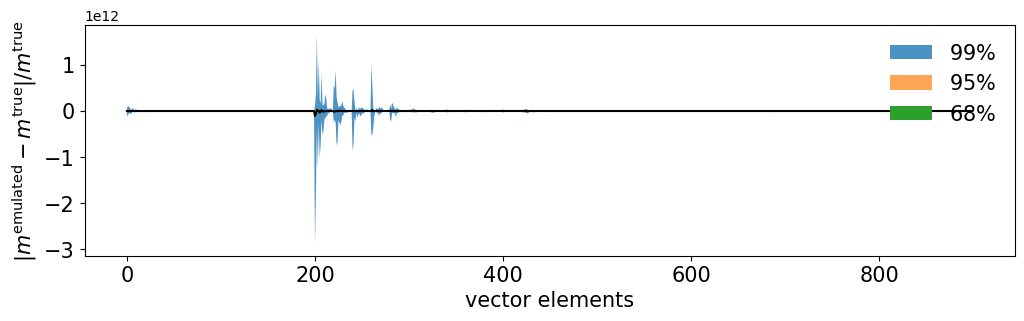

In [31]:
emulated_features = cp_nn.predictions_np(test_params)
# if you modified the training features you need to convert back the output back the original data vectors

emulated_features = emulated_features + minimum_feature
emulated_features = emulated_features*maximum_feaure

diff=(emulated_features/test_features-1) # Measure the relative difference between test sample and the emualted models

mean_diff = np.mean(diff,0)
percentiles1 = np.percentile(diff, [50-34, 50+34],axis=0) 
percentiles2 = np.percentile(diff, [50-(95/2), 50+(95/2)], axis=0) 
percentiles3 = np.percentile(diff, [50-(99/2), 50+(99/2)], axis=0)
bins=range(diff.shape[1])

# print(bins)
# print(percentiles1[0])
# print(percentiles1[1])

plt.figure(figsize=(12, 3),dpi=100)
plt.fill_between(bins, percentiles3[0], percentiles3[1], label = '$99\%$', alpha=0.8)
plt.fill_between(bins, percentiles2[0], percentiles2[1], label = '$95\%$', alpha = 0.7)
plt.fill_between(bins, percentiles1[0], percentiles1[1], label = '$68\%$', alpha = 1)
plt.plot(bins, mean_diff,'-',color='black')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(frameon=False, fontsize=15, loc='upper right')
plt.ylabel(r'$| m^{\mathrm{emulated}} - m^{\mathrm{true}}|/  m^{\mathrm{true}}$', fontsize=15)
plt.xlabel(r'vector elements',  fontsize=15)
#plt.ylim(-0.001,0.001)
plt.show()


##### Next we want perform a Fisher Analysis using the emulator. We want you to compute the covariance of the parameters $\Theta = \{\Omega_\mathrm{m},w\}$, which can be estimated by $C(\Theta) = F^{-1}$, where $$F_{ij}= \left(\frac{\partial m(\Theta)}{\partial \Theta_i}\right)^{T} C^{-1} \left(\frac{\partial m(\Theta)}{\partial \Theta_i}\right)$$
##### For the partial derivatives we use the five point stencil beam given by $$\frac{\partial m(\Theta)}{\partial \Theta_i}\approx \frac{-m(\Theta_i + 2\ \Delta \Theta_i) + 8 \ m(\Theta_i +  \Delta \Theta_i) - 8 \ m(\Theta_i - \Delta \Theta_i) + m(\Theta_i - 2\ \Delta \Theta_i)}{12 \ \Delta \Theta_i }$$

In [5]:
Om_shift = 0.01 #decide for a reasonable stepsize in Omega_m
w_shift = 0.01 #decide for a reasonable stepsize in w

# This example compute the model for two different Omega_m values.
paramters = {'omega_m':[0.3,0.31,],'w':[-1,-1],'As':[np.mean(test_params['As'])]*2,'omega_b':[np.mean(test_params['omega_b'])]*2}
    
features_4_div = cp_nn.predictions_np(paramters)
# if you modified the training features you need to convert back the output back the original data vectors
# Undoing the normalzation performed on the data
features_4_div = features_4_div + minimum_feature
features_4_div = features_4_div*maximum_feaure

print(features_4_div)
derivative_Om = ... # compute derivative
derivative_w = ... # compute derivative



NameError: name 'cp_nn' is not defined

#### So lets compute the Fisher matrix the corresponding covariance matrix of the paramters:

In [ ]:
cov=np.load('data_4_assignment1/covariance.npy') # We make use of the analy
inv_cov = inv(cov)

FoM_11 = ...
FoM_22 = ...
FoM_12 = ...
FoM_best = np.array([[FoM_11,FoM_12],[FoM_12,FoM_22]])

Cov_parameter = ...
Cov_parameter,np.sqrt(np.diag(Cov_parameter))


#### First you need to generate the transformation from our model/data vectors to the PCA elements based on the 10k models. Then you need transform all 100k noisy data vectors from which you should then measure the a cvoavraicen on the PCA elements. Now it should get clear why you had to genereate the 100k multvariate Gaussian random variables. 

In [ ]:
from sklearn.decomposition import PCA

N_pca = 900 # Decide how many PCA eigenvalues you want to use
models = np.load('data_4_assignment2/models.npy')
mean = np.mean(models,axis=0) # for numerical stability you should subtract the mean of each element
pca = PCA(n_components=N_pca,svd_solver='full')
models_pca = pca.fit_transform(models-mean) # Perform the PCA fitting. Now you can use pca for the transformation

#rotate covariance matrix. If you do not how to do that. You can also create 10k random data vectors and tranform each one individual, 
# and the compute the covariance matrix from them
rotation_matrix = pca.components_.T
cov_pca = ...

plt.imshow(cov_pca/np.outer(np.sqrt(np.diag(cov_pca)),np.sqrt(np.diag(cov_pca))),vmin=-1)
plt.colorbar()
plt.show()





#### Increase successively the number of PCA elements from which you compute the Fisher matrix. Convince yourself that if you take all possible PCA elements you converge to same contraining power as for original Fisher analysis. How many PCA elements do you need to have 10% and 1% of the constraining power as the original Fisher analysis?

In [ ]:
paramter_constraints = []
for N_pca in np.arange(1,900):
    
    inv_cov_pca = ... # select the first N_pca elements

    features_4_div_pca = pca.transform(...) # transform  the dverative and select the first N_pca elements


    derivative_Om_pca = ... # compute derivative
    derivative_w_pca = ... # compute derivative

    FoM_11 = ...
    FoM_22 = ...
    FoM_12 = ...
    FoM_best_pca = np.array([[FoM_11,FoM_12],[FoM_12,FoM_22]])

    Cov_parameter_pca = inv(FoM_best_pca)
    paramter_constraints.append(np.sqrt(np.diag(Cov_parameter_pca)))
paramter_constraints = np.array(paramter_constraints)

### Plot the constraints depending on the number of PCA that you have used. How many PCA elements do you need to get 10% and 1% of the maximum constraining power.